[View in Colaboratory](https://colab.research.google.com/github/Tzeny/cifar10/blob/master/Cifar10.ipynb)

This is my attempt at solving the Cifar10 challenge. This file is also available on GitHub: [https://github.com/Tzeny/cifar10/blob/master/Cifar10.ipynb](https://github.com/Tzeny/cifar10/blob/master/Cifar10.ipynb)



|Model architecture | Optimizer | Batch size  | Train images | Stop epoch | Test accuracy |
|------------- |---|-------------|----|
|2 x inception(w dr 3,36) 2 x (conv(144ft)+maxpool) flt 2 x dense (w dr) act \[w batch normalization\]|Adam(0.001)|128|Normalized color |~20|~93 %
|3 x inception(w dr 3, 36,216) (conv(288ft)+maxpool) flt 2 x dense (w dr) \[w batch normalization\]|Adam(0.001)|128|Normalized color|65|86.37 %

>[Google Colab ensure we have our own GPU](#scrollTo=nZ-oiI4YlXGL)

>[Connecting to Google Drive](#scrollTo=sqKMRov-lQjI)

>[Prepare our dataset](#scrollTo=l-LAEOiUmMgt)

>[Model definition and training](#scrollTo=xmoQDAurmSbS)

>[Model evaluation](#scrollTo=f53m3bg_p5rk)



# Google Colab ensure we have our own GPU

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /content/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /content/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 12.8 GB  | Proc size: 139.6 MB
GPU RAM Free: 11438MB | Used: 1MB | Util   0% | Total 11439MB


In [0]:
 !kill -9 -1

# Connecting to Google Drive

In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p my_drive
!google-drive-ocamlfuse my_drive
!ls my_drive/ai


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
kaggle	projects


# Prepare our dataset

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(451)

from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

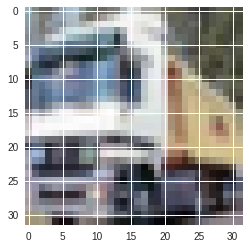

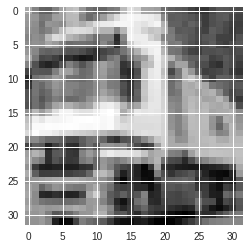

In [13]:
#gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
x_train_gray = np.dot(x_train[:,:,:,:3], [0.299, 0.587, 0.114])
x_test_gray = np.dot(x_test[:,:,:,:3], [0.299, 0.587, 0.114])

x_train_gray = x_train_gray.reshape(-1,32,32,1)
x_test_gray = x_test_gray.reshape(-1,32,32,1)

from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

plt.imshow(x_train[1])
plt.show()

plt.imshow(x_train_gray[1,:,:,0], cmap='gray')
plt.show()

# Model definition and training

In [19]:
np.random.seed(451)

import datetime

from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Flatten, Activation, Conv2D, AvgPool2D, Dense, Dropout, concatenate
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json, Model

def build_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, (1,1), padding='same', activation='relu', 
                     kernel_regularizer=regularization, name='tower_%d_%dx%da'%(tower_nr, shape[0], shape[1]))(input_layer)
    tower = Conv2D(features_nr*2, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, name='tower_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(tower)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, 
                   name='tower_simple_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(input_layer)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_simple_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_dense(input_layer, neurons_nr, dense_nr, 
                dropout=False, normalization=False, regularization='l2', dropout_ratio=0.5):
    dense = Dense(neurons_nr, kernel_regularizer=regularization, 
                  name='dense_%d_%d'%(dense_nr, neurons_nr))(input_layer)
    
    if dropout:
        dense = Dropout(dropout_ratio, name='dense_%d_%ddrop'%(dense_nr, neurons_nr))(dense)
    if normalization:
        dense = BatchNormalization(name='dense_%d_%dnorm'%(dense_nr, neurons_nr))(dense)
    
    return dense

def build_inception_module(input_layer, features_nr, module_nr, 
                           dropout=False, normalization=False, regularization='l2', dropout_ratio=0.2):  
    tower_1 = build_tower(input_layer, features_nr, (3,3), module_nr, 
                          dropout, normalization, regularization, dropout_ratio)

    tower_2 = build_tower(input_layer, features_nr, (5,5), module_nr, 
                          dropout, normalization, regularization, dropout_ratio)

    #max pooling tower
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same', name='inception_%d_pool3x3a'%(module_nr))(input_layer)
    tower_3 = Conv2D(features_nr*2, (1,1), padding='same', activation='relu',
                    kernel_regularizer=regularization, name='inception_%d_pool3x3b'%(module_nr))(tower_3)
    if dropout:
        tower_3 = Dropout(dropout_ratio, name='inception_%d_pool3x3drop'%(module_nr))(tower_3)
    if normalization:
        tower_3 = BatchNormalization(name='inception_%d_pool3x3norm'%(module_nr))(tower_3)

    #concatenate and subsample towers
    output = concatenate([tower_1, tower_2, tower_3], axis = 3, name='inception_%d_concat'%(module_nr))

    pooled = MaxPooling2D((2,2), padding='same', name='inception_%d_2x2subsample'%(module_nr))(output)
    
    return pooled

i='cifar10-'+datetime.datetime.now().strftime("%I:%M%p_%B-%d-%Y")

K.clear_session()

!mkdir -p models
!mkdir -p logs

a = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')#will stop the model if val_loss does not improve for 2 consecutive epochs
b = ModelCheckpoint(monitor='val_loss', filepath='./models/'+str(i)+'.hdf5', verbose=1, save_best_only=True)#save model weights after each epoch if val_loss improves
c = TensorBoard(log_dir='./logs/'+str(i),
                write_grads=True,
                write_graph=True,
                write_images=True,
                batch_size=128)#saves a log file for tensorboard; remember to save different runs to different subdirectories

#we'll use this instead of decay
d = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[a,b,c,d]

#------------model definition-------------------

use_norm = True
lrate = 0.001

input_img = Input(shape = (32, 32, 3), name='input')

#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
               # kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

#hopefully this will learn a good internal representation of the image channels
#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
                #kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

inception_1 = build_inception_module(input_img, 3, 1, True, use_norm)

inception_2 = build_inception_module(inception_1, 36, 2, True, use_norm)

inception_3 = build_inception_module(inception_2, 216, 3, True, use_norm)

#tower_3 = build_simple_tower(inception_2, 144, (3,3),  3, False, use_norm)
#tower_4 = build_simple_tower_subsample(tower_3, 144, (3,3), 4, False, use_norm)

tower_5 = build_simple_tower(inception_3, 288, (3,3),  5, False, use_norm)
tower_6 = build_simple_tower_subsample(tower_5, 288, (3,3), 6, False, use_norm)

#model top

flat = Flatten()(tower_6)

dense_5 = build_dense(flat, 128, 1, True, use_norm)

dense_6 = build_dense(dense_5, 64, 2, True, use_norm)

out = Dense(10, activation='softmax')(dense_6)

model = Model(inputs = input_img, outputs = out)

#-----------------------------------------------

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lrate),
              metrics=['accuracy'])

model.summary()

model_json = model.to_json()
with open("./models/"+str(i)+".json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to" + "../models/"+str(i)+".json")


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
tower_1_3x3a (Conv2D)           (None, 32, 32, 3)    12          input[0][0]                      
__________________________________________________________________________________________________
tower_1_5x5a (Conv2D)           (None, 32, 32, 3)    12          input[0][0]                      
__________________________________________________________________________________________________
inception_1_pool3x3a (MaxPoolin (None, 32, 32, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
tower_1_3x

In [20]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
  
print("Memory usage (GB):", get_model_memory_usage(128,model))

Memory usage (GB): 4.048


In [21]:
import tensorflow as tf

with tf.device('/gpu:0'):
  model.fit(x_train, y_train_cat, batch_size=128, epochs=100, validation_split=0.2,verbose=1,callbacks=callbacks)  # starts training

result = model.evaluate(x_test, y_test_cat)

print("Accuracy on test set: ",result[1]*100,"%")

#copy our generated model and logs to GoogleDrive
!cp -R models my_drive/ai/projects/cifar10
!cp -R logs my_drive/ai/projects/cifar10

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 72s 2ms/step - loss: 2.5105 - acc: 0.8954 - val_loss: 0.4420 - val_acc: 0.9000

Epoch 00001: val_loss improved from inf to 0.44198, saving model to ./models/cifar10-07:25AM_July-07-2018.hdf5
Epoch 2/100
17280/40000 [===========>..................] - ETA: 34s - loss: 0.3564 - acc: 0.8995

40000/40000 [==============================] - 64s 2ms/step - loss: 0.3385 - acc: 0.9004 - val_loss: 0.4282 - val_acc: 0.8999

Epoch 00002: val_loss improved from 0.44198 to 0.42820, saving model to ./models/cifar10-07:25AM_July-07-2018.hdf5
Epoch 3/100
31488/40000 [======================>.......] - ETA: 12s - loss: 0.3076 - acc: 0.9038

40000/40000 [==============================] - 64s 2ms/step - loss: 0.3050 - acc: 0.9040 - val_loss: 0.3714 - val_acc: 0.9016

Epoch 00003: val_loss improved from 0.42820 to 0.37139, saving model to ./models/cifar10-07:25AM_July-07-2018.hdf5
Epoch 4/100
19072/40000 [=============>................] - ETA: 31s - loss: 0.2961 - acc: 0.9055

KeyboardInterrupt: ignored

# Model evaluation

In [14]:
model.load_weights('./models/cifar10-06:43AM_July-07-2018.hdf5')

result = model.evaluate(x_test, y_test_cat)

print(result)

10000/10000 [==============================] - 6s 578us/step
[0.20430024523735046, 0.9331499870300293]
